# Installing Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install openai

In [ ]:
!pip install anthropic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 862.7/862.7 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 33.5 MB/s eta 0:00:00


# Data Preprocessing

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Install and Download the required resources for NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Read CSV file
df = pd.read_csv('Original_Instagram_Full.csv')

# Clean text
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'\W+', ' ', text)
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove text starting with single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # Remove leading spaces
    text = text.strip()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    text = ' '.join(filtered_text)
    return text

# Apply the cleaning function and store results in a new column
df['preprocessing_review_description'] = df['review_description'].apply(clean_text)

# Save the cleaned data with UTF-8 encoding
df.to_csv('Preprocessed_Instagram_Full.csv', index=False, encoding='utf-8')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# GPT-4o

In [ ]:
import openai
import pandas as pd
from google.colab import userdata

# Set OpenAI API key
openai.api_key = userdata.get('OPENAI_API_KEY')

def get_sentiment(text):
    prompt = f"Based on the text provided, give only the sentiment score (from -1 to 1) and sentiment tendency (positive, negative, or neutral). Do not include any analysis or rationale:\nText: {text}\n"
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        max_tokens=60,
        temperature=0.3
    )
    text = response.choices[0].message.content.strip()

    # Parse the returned text
    lines = text.split('\n')
    score = None
    for line in lines:
        if "sentiment score" in line.lower():
            try:
                score = float(line.split(': ')[1])
                break
            except (IndexError, ValueError):
                continue

    if score is not None:
        score = round(score, 2)
        if score > 0.1:
            tendency = 'Positive'
        elif score < -0.1:
            tendency = 'Negative'
        else:
            tendency = 'Neutral'
        return score, tendency
    else:
        print(f"Warning: Could not extract a valid sentiment score for text: {text}")
        return None, None

# Read file
input_file_path = 'Preprocessed_Instagram_Sampled.csv'
df = pd.read_csv(input_file_path, encoding='utf-8')

# Calculate Sentiment Score and Tendency
df[['gpt4o_scores', 'gpt4o_tendency']] = df.apply(lambda row: pd.Series(get_sentiment(row['preprocessing_review_description'])), axis=1)

# Save results to a new CSV file
output_file_path = "gpt4o_output.csv"
df.to_csv(output_file_path, index=False, encoding='utf-8')

print(f"Results saved to: {output_file_path}")

Results saved to: /content/drive/MyDrive/NTPUMIS/AI in Big Data Analysis_小組/gpt4o_instagram_1-10000.csv


# GPT-3.5 Turbo

In [ ]:
import openai
import pandas as pd

# Set OpenAI API key
openai.api_key = 'OPENAI_API_KEY'

def get_sentiment(description):
    prompt = f"Based on the description provided, give a sentiment score (from -1 to 1) and sentiment tendency (positive, negative, or neutral):\nDescription: {description}\n"
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}],
        max_tokens=60,
        temperature=0.3
    )
    text = response.choices[0].message.content.strip()

    # Print returned text for checking its format
    print("Returned text:", text)

    # Parse returned text
    lines = text.split('\n')
    score = None
    for line in lines:
        if "sentiment score" in line.lower():
            score = float(line.split(': ')[1])

    if score is not None:
        if score > 0.1:
            tendency = 'Positive'
        elif score < -0.1:
            tendency = 'Negative'
        else:
            tendency = 'Neutral'
        return score, tendency
    else:
        raise ValueError("Returned text does not contain the expected format for sentiment score and tendency.")

# Read file
file_path = 'gpt4o_output.csv'
df = pd.read_csv(file_path)

# Calculate Sentiment Score and Tendency
df[['gpt3.5_scores', 'gpt3.5_tendency']] = df.apply(lambda row: pd.Series(get_sentiment(row['preprocessing_review_description'])), axis=1)

# Save result
output_file_path = 'gpt3.5_turbo_output.csv'
df.to_csv(output_file_path, index=False)

# Display a part of the result
df

Returned text: Sentiment score: 0.1
Sentiment tendency: Neutral
Returned text: Sentiment score: -0.6
Sentiment tendency: negative
Returned text: Sentiment score: 0.8
Sentiment tendency: Positive
Returned text: Sentiment score: -0.8
Sentiment tendency: Negative
Returned text: Sentiment score: -0.7
Sentiment tendency: Negative
Returned text: Sentiment score: -0.7
Sentiment tendency: Negative
Returned text: Sentiment score: -0.4
Sentiment tendency: Negative
Returned text: Sentiment score: -0.2
Sentiment tendency: Negative
Returned text: Sentiment score: -0.2
Sentiment tendency: Negative
Returned text: Sentiment score: -0.6
Sentiment tendency: Negative
Returned text: Sentiment score: -0.2
Sentiment tendency: Negative
Returned text: Sentiment score: -0.4
Sentiment tendency: Negative
Returned text: Sentiment score: -0.6
Sentiment tendency: Negative
Returned text: Sentiment score: -0.6
Sentiment tendency: Negative
Returned text: Sentiment score: 0.2
Sentiment tendency: Neutral
Returned text: 

,review_description,rating,review_date,preprocessing_review_description,gpt4o_scores,gpt4o_tendency,gpt3.5_scores,gpt3.5_tendency
0,"The app is good for connecting with friends, f...",3,2023/7/11 23:57,app good connecting friends family even potent...,0.2,Positive,0.1,Neutral
1,"Used to be my favorite social media app, but ""...",2,2023/7/22 21:37,used favorite social media app improvements ma...,-0.9,Negative,-0.6,Negative
2,Instagram is the best of all the social media....,5,2023/7/25 03:24,instagram best social media ig posting platfor...,0.8,Positive,0.8,Positive
3,"I love this app.. but as of late, I have been ...",2,2023/7/9 04:49,love app late problems screen background turni...,-0.8,Negative,-0.8,Negative
4,Used to be a great app but there are so many m...,3,2023/7/17 16:47,used great app many bugs issues ever plus ruin...,-0.8,Negative,-0.7,Negative
...,...,...,...,...,...,...,...,...
969,The most annoying part of this app for me is t...,1,2023/7/9 20:10,annoying part app fact post picture camera rol...,-0.8,Negative,-0.6,Negative
970,Overaya good one but my highlights have not be...,4,2023/7/20 13:30,overaya good one highlights working since plea...,-0.2,Negative,-0.6,Negative
971,I've had so many problems with this app lately...,3,2023/5/21 22:23,many problems app lately usually fine noticed ...,-0.8,Negative,-0.3,Negative
972,Can't view my insights because apparently ther...,1,2023/7/19 08:03,view insights apparently error boost ads somet...,-0.8,Negative,-0.6,Negative


# Claude 3 Haiku

In [ ]:
import anthropic
import csv
import re

client = anthropic.Anthropic(
    api_key="CLAUDE_HAIKU_KEY"
)

input_file = "gpt3.5_turbo_output.csv"
output_file = "claude_haiku_output.csv"

with open(input_file, "r", encoding='utf-8') as file:
    reader = csv.DictReader(file)
    rows = list(reader)

results = []

for row in rows:
    description = row["preprocessing_review_description"]

    message = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=50,
        temperature=0.6,
        system="""
        Please analyze the sentiment of the following description and provide a sentiment score ranging from -1 to 1, along with the sentiment tendency (positive, negative, or neutral) in the following format: 'Sentiment Score: <score> Sentiment Tendency: <tendency>'.

        Use the following criteria for sentiment tendency:
        Positive: Sentiment score from 0.1 to 1.0. This means that when the sentiment score is within this range, the content is considered to be positive.
        Neutral: Sentiment score between -0.1 and 0.1. This means the sentiment is neither strongly positive nor strongly negative, and is therefore judged to be neutral.
        Negative: Sentiment score from -1.0 to -0.1. This means that when the sentiment score is within this range, the content is considered to be negative.
        """,
        messages=[
            {
                "role": "user",
                "content": f"Description: {description}"
            }
        ]
    )

    result_text = message.content[0].text.strip()
    sentiment_score = re.search(r"Sentiment Score: ([-+]?[0-9]*\.?[0-9]+)", result_text).group(1)
    sentiment_tendency = re.search(r"Sentiment Tendency: (\w+)", result_text).group(1)

    row["haiku_scores"] = sentiment_score
    row["haiku_tendency"] = sentiment_tendency
    results.append(row)

fieldnames = list(rows[0].keys()) + ["haiku_scores", "haiku_tendency"]

with open(output_file, "w", newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(results)

# Model Evaluation

In [ ]:
import pandas as pd
import plotly.express as px

# Check the structure of the dataframe
tendency_df.head()

# Recreate the chart, using group separation to show each sentiment
fig = px.bar(tendency_df, x='Model', y='Count', color='Sentiment', text='Count',
             title='Count of Sentiment Tendencies Across Models',
             color_discrete_map={'Positive': '#957DAD', 'Neutral': '#D291BC', 'Negative': '#FEC8D8'},
             barmode='group')

# Update the text settings so that it appears above the bars
fig.update_traces(texttemplate='%{text:.0f}', textposition='outside')

# Update the layout for better readability
fig.update_layout(
    xaxis_title='Model',
    yaxis_title='Counts',
    plot_bgcolor='white',
    uniformtext_minsize=8, uniformtext_mode='hide'
)

fig.show()

In [ ]:
import pandas as pd

# Load the data
file_path = 'claude_haiku_output.csv'
data = pd.read_csv(file_path)

# Ensure 'gpt4o_scores', 'gpt3.5_scores', 'haiku_scores', and 'rating' are numeric types
data['gpt4o_scores'] = pd.to_numeric(data['gpt4o_scores'], errors='coerce')
data['gpt3.5_scores'] = pd.to_numeric(data['gpt3.5_scores'], errors='coerce')
data['haiku_scores'] = pd.to_numeric(data['haiku_scores'], errors='coerce')
data['rating'] = pd.to_numeric(data['rating'], errors='coerce')

# Remove any rows with NaN values after conversion
data.dropna(subset=['gpt4o_scores', 'gpt3.5_scores', 'haiku_scores', 'rating'], inplace=True)

# Check if the 'rating' column exists and calculate correlations
if 'rating' in data.columns:
    correlation_gpt4o = data['gpt4o_scores'].corr(data['rating'])
    correlation_gpt35 = data['gpt3.5_scores'].corr(data['rating'])
    correlation_haiku = data['haiku_scores'].corr(data['rating'])

    print("Correlation between GPT-4o scores and rating:", correlation_gpt4o)
    print("Correlation between GPT-3.5 scores and rating:", correlation_gpt35)
    print("Correlation between Haiku scores and rating:", correlation_haiku)
else:
    print("The 'rating' column does not exist in the dataset. Please check the dataset or provide the correct column name for rating.")

Correlation between GPT-4o scores and rating: 0.6312581393705997
Correlation between GPT-3.5 scores and rating: 0.5178398809580543
Correlation between Haiku scores and rating: 0.562991780116074


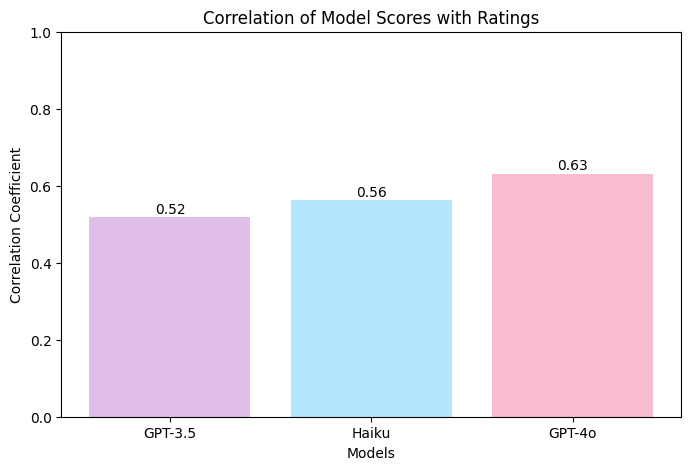

In [ ]:
import matplotlib.pyplot as plt

# Correlation data
correlations = {
    'GPT-3.5': 0.5178398809580543,
    'Haiku': 0.562991780116074,
    'GPT-4o': 0.6312581393705997
}

# Convert correlation data into lists for plotting
models = list(correlations.keys())
values = list(correlations.values())

# Use lighter colors
colors = ['#E1BEE7', '#B3E5FC', '#F8BBD0']

# Create bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(models, values, color=colors)

# Add chart title and axis labels
plt.title('Correlation of Model Scores with Ratings')
plt.xlabel('Models')
plt.ylabel('Correlation Coefficient')

# Display data labels on the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 0.01, f'{value:.2f}', ha='center')

# Show the chart
plt.ylim(0, 1)
plt.show()